## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

False

And in this cell we pass the environment variable to tidycensus in R

In [9]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY"),overwrite=TRUE) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [38]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variable = c(
                        total_pop_25 = "B15003_001",   # Total population 25+
                        more_than_oney_college = c("B15003_020","B15003_021","B15003_022","B15003_023","B15003_024","B15003_025")
                          
                      ), 
                      year = 2023,
                      survey="acs5",
                      geometry=T
                    
)

nyc_census_data


Simple feature collection with 16289 features and 5 fields (with 21 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME
1  36005023502 Census Tract 235.02; Bronx County; New York
2  36005023502 Census Tract 235.02; Bronx County; New York
3  36005023502 Census Tract 235.02; Bronx County; New York
4  36005023502 Census Tract 235.02; Bronx County; New York
5  36005023502 Census Tract 235.02; Bronx County; New York
6  36005023502 Census Tract 235.02; Bronx County; New York
7  36005023502 Census Tract 235.02; Bronx County; New York
8  36005013500    Census Tract 135; Bronx County; New York
9  36005013500    Census Tract 135; Bronx County; New York
10 36005013500    Census Tract 135; Bronx County; New York
                  variable estimate moe                       geometry
1             total_pop_25     2

Getting data from the 2019-2023 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [39]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 16 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 17
   GEOID       NAME                               geometry total_pop_25_estimate
   <chr>       <chr>                    <MULTIPOLYGON [°]>                 <dbl>
 1 36005023502 Census Tract 235… (((-73.906 40.84939, -73…                  2765
 2 36005013500 Census Tract 135… (((-73.90508 40.82711, -…                  2170
 3 36005009200 Census Tract 92;… (((-73.85773 40.83356, -…                  3933
 4 36005005400 Census Tract 54;… (((-73.88389 40.82981, -…                  3283
 5 36005036501 Census Tract 365… (((-73.88832 40.84518, -…                  2979
 6 36005044902 Census Tract 449… (((-73.87136 40.90004, -…                  1824
 7 36005017500 Census Tract 175… (((-73.9157 40.83054, -7…                  3852
 8 36005021900 Censu

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [43]:
%%R

colnames(nyc_census_data)

 [1] "GEOID"                            "NAME"                            
 [3] "geometry"                         "total_pop_25_estimate"           
 [5] "more_than_oney_college1_estimate" "more_than_oney_college2_estimate"
 [7] "more_than_oney_college3_estimate" "more_than_oney_college4_estimate"
 [9] "more_than_oney_college5_estimate" "more_than_oney_college6_estimate"
[11] "total_pop_25_moe"                 "more_than_oney_college1_moe"     
[13] "more_than_oney_college2_moe"      "more_than_oney_college3_moe"     
[15] "more_than_oney_college4_moe"      "more_than_oney_college5_moe"     
[17] "more_than_oney_college6_moe"     


In [46]:
%%R 
nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ";") %>% map_chr(2) %>% str_trim(),
        beyond_oney_sum = (more_than_oney_college1_estimate + more_than_oney_college2_estimate + more_than_oney_college3_estimate +
                           more_than_oney_college4_estimate + more_than_oney_college5_estimate),
        
    pct_beyond_oney = beyond_oney_sum / total_pop_25_estimate * 100) 
nyc_census_data

Simple feature collection with 2327 features and 19 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 20
   GEOID       NAME                               geometry total_pop_25_estimate
 * <chr>       <chr>                    <MULTIPOLYGON [°]>                 <dbl>
 1 36005023502 Census Tract 235… (((-73.906 40.84939, -73…                  2765
 2 36005013500 Census Tract 135… (((-73.90508 40.82711, -…                  2170
 3 36005009200 Census Tract 92;… (((-73.85773 40.83356, -…                  3933
 4 36005005400 Census Tract 54;… (((-73.88389 40.82981, -…                  3283
 5 36005036501 Census Tract 365… (((-73.88832 40.84518, -…                  2979
 6 36005044902 Census Tract 449… (((-73.87136 40.90004, -…                  1824
 7 36005017500 Census Tract 175… (((-73.9157 40.83054, -7…                  3852
 8 36005021900 Censu

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 84 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 84 rows containing missing values or values outside the scale range
(`geom_point()`). 



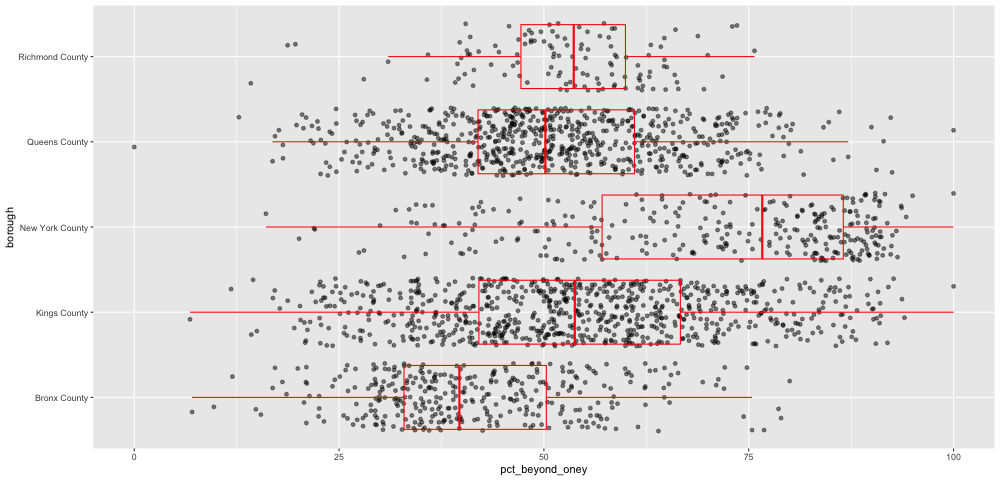

In [48]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=pct_beyond_oney, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

# your code here. refer to example notebooks for help


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

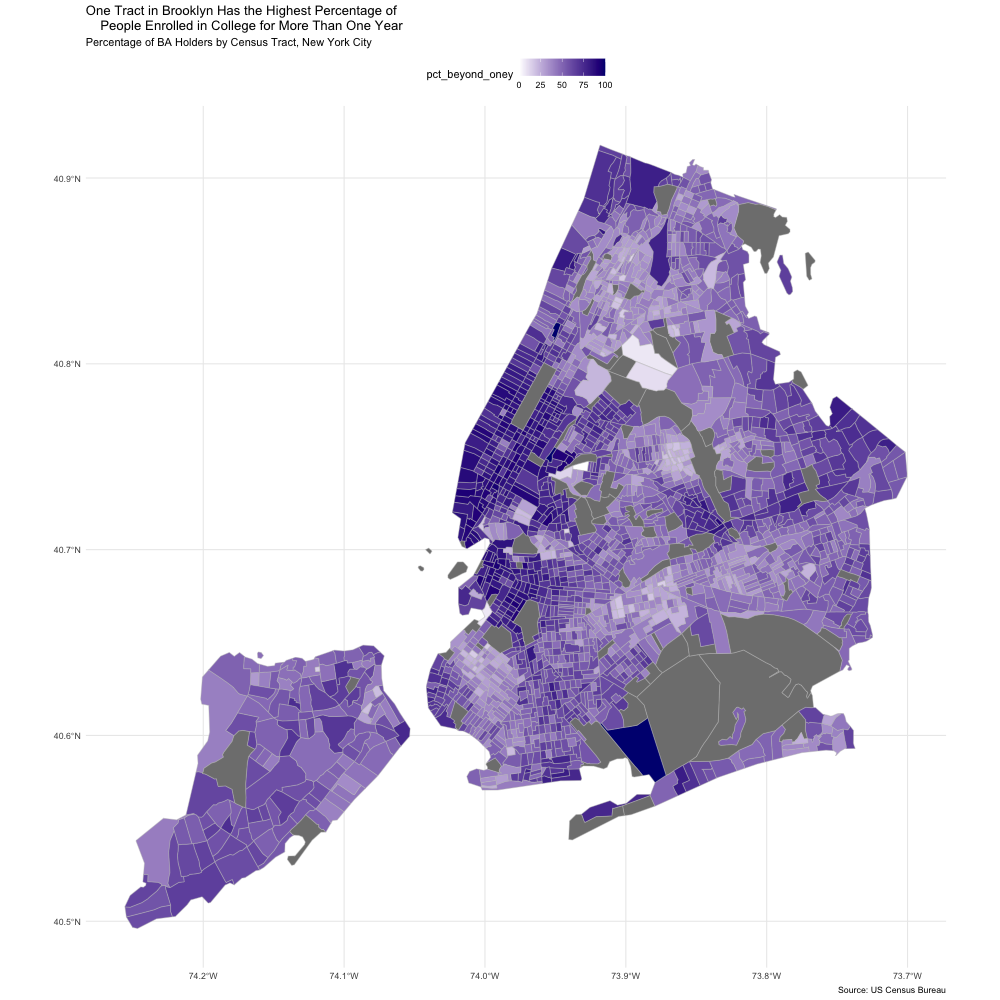

In [52]:
%%R -w 1000 -h 1000

# your code here. refer to example notebooks for help
education <- nyc_census_data %>%
  ggplot(aes(fill = pct_beyond_oney)) + 
  geom_sf(color = 'grey') + 
  scale_fill_gradient(low="white", high="navyblue") + 
  labs(
    title = "One Tract in Brooklyn Has the Highest Percentage of 
    People Enrolled in College for More Than One Year",
    subtitle = "Percentage of BA Holders by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  ) +
    theme_minimal() +
    theme(legend.position = "top",
    plot.title = element_text(hjust = 0))

education

In [53]:
%%R

ggsave("Education_NYC.png",education)

Saving 6.67 x 6.67 in image
